In [1]:
import os, shutil, gc, glob

import hda
from getpass import getpass

import xarray as xr
import numpy as np
import cf_xarray, rioxarray

import time
from datetime import datetime, timedelta

from cdo import *
cdo = Cdo()
cdo.cleanTempDir()

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
import colormaps as cmo

from cartopy import crs as ccrs
from cartopy import feature as cf

import zipfile

from rich.jupyter import print as rprint
from rich.table import Table
from rich.markdown import Markdown

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

In [2]:
download_dir = os.path.join(os.path.expanduser('~'),"sentinel-3_program","downloaded-data")
result_dir = os.path.join(os.path.expanduser('~'),"sentinel-3_program","processed-data")

os.makedirs(download_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

In [3]:
list_flags_common = ['LAND','INLAND_WATER','COASTLINE','CLOUD','CLOUD_AMBIGUOUS','CLOUD_MARGIN','INVALID','COSMETIC','SATURATED','SUSPECT','HISOLZEN','HIGHGLINT','SNOW_ICE']
list_flags_process = ['AC_FAIL','WHITECAPS','ADJAC','RWNEG_O2','RWNEG_O3','RWNEG_O4','RWNEG_O5','RWNEG_O6','RWNEG_O7','RWNEG_O8']
list_flags_oc4me = ['OC4ME_FAIL','TIDAL']
list_flags_ocnn = ['OCNN_FAIL']

def flag_data_fast(list_flag, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    for flag in list_flag:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + 'not present')
    return (flag_data & flag_bits) > 0			


In [4]:
os.system('cls' if os.name == 'nt' else 'clear') 

intro_md = '''
# Welcome to Sentinel-3 OLCI Biogeochemical Data Access Program

This program is developed by Edwards Taufiqurrahman and the Integrated Marine Biosphere Research Group, Research Centre for Oceanography, National Research and Innovation Agency, Indonesia.

At first, you will be asked the WEkEO `Username` and `Password` and data that you need. Therefore, before start, please make sure that you have a WEkEO Account (you can create one from this link: [https://www.wekeo.eu/register](https://www.wekeo.eu/register)) and you should already know some information about data that you need.

### Enter your WEkEO Credential
'''

rprint(Markdown(intro_md))

print()

while True:
    try:
        user = input("Enter your WEkEO username: ")
        passw = getpass("Enter your WEkEO password: ")
        c = hda.Client(hda.Configuration(user=user, password=passw), progress=True, max_workers=1)
        print()
        print(f"Login successfull!. Your token is {c.token}.")
        break
    except KeyError:
        print()
        print('You entered wrong username and/or password.')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                          Welcome to Sentinel-3 OLCI Biogeochemical Data Access Program                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

This program is developed by Edwards Taufiqurrahman and the Integrated Marine Biosphere Research Group, Research   
Centre for Oceanography, National Research and Innovation Agency, Indonesia.                                       

At first, you will be asked the WEkEO Username and Password and data that you need. Therefore, before start, please
make sure that you have a WEkEO Account (you can create one from this link: ]8;id=406204;https://www.wekeo.eu/register\https://www.wekeo.eu/register]8;;\) and you 
should already know some information about data that you need.                                                     

                                            Enter your WEkEO Credential

Enter your WEkEO username:  edskywalker
Enter your WEkEO password:  ········



Login successfull!. Your token is 0642e12a-7863-3b13-8966-9283e7f71ef0.


In [5]:
time.sleep(1)
os.system('cls' if os.name == 'nt' else 'clear') 

sat_md_1 = '''
### Enter Satellite Parameters

Sentinel-3 is available in two satellites: Sentinel-3A and Sentinel-3B. Please note that Sentinel-3B is only available from 18 May 2018.

The Sentinel-3 dataset in WEkEO available in two time period `EO:EUM:DAT:SENTINEL-3:0556` (2016 - 2021) and `EO:EUM:DAT:SENTINEL-3:OL_2_WFR___` (2021 - recent)

#### Enter the satellite designation (`A` or `B`):

- Sentinel-3**A**
- Sentinel-3**B**

Leave it blank if you want both Sentinel-3A and Sentinel-3B queried.

'''

rprint(Markdown(sat_md_1))
print()

sat_nm = input("Satellite name: ")

print()

if sat_nm == 'a' or sat_nm == 'A':
    sat = 'Sentinel-3A'
    print()
elif sat_nm == 'b' or sat_nm == 'B':
    sat = 'Sentinel-3B'
    print()
else:
    sat = ''
    print()

sat_md_2 = '''
#### Enter Sentinel-3 dataset ID (`1` or `2`)

1. EO:EUM:DAT:SENTINEL-3:0556
2. EO:EUM:DAT:SENTINEL-3:OL_2_WFR___
'''

rprint(Markdown(sat_md_2))

print()

while True:
    sat_id = int(input('Satellite ID: '))

    if sat_id == 1:
        dataset_id = 'EO:EUM:DAT:SENTINEL-3:0556'
        print()
        break
    elif sat_id == 2:
        dataset_id = 'EO:EUM:DAT:SENTINEL-3:OL_2_WFR___'
        print()
        break
    else:
        print()
        rprint("You put wrong number. Please try again!")

print()

Enter Satellite Parameters                                             

Sentinel-3 is available in two satellites: Sentinel-3A and Sentinel-3B. Please note that Sentinel-3B is only       
available from 18 May 2018.                                                                                        

The Sentinel-3 dataset in WEkEO available in two time period EO:EUM:DAT:SENTINEL-3:0556 (2016 - 2021) and          
EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ (2021 - recent)                                                                  

                                     Enter the satellite designation (A or B):                                     

 • Sentinel-3A                                                                                                     
 • Sentinel-3B                                                                                                     

Leave it blank if you want both Sentinel-3A and Sentinel-3B queried.

Satellite name:  a


Enter Sentinel-3 dataset ID (1 or 2)                                        

 1 EO:EUM:DAT:SENTINEL-3:0556                                                                                      
 2 EO:EUM:DAT:SENTINEL-3:OL_2_WFR___

Satellite ID:  1


In [7]:
time.sleep(1)
os.system('cls' if os.name == 'nt' else 'clear') 

area_md = '''
Please input your area of interest. The coordinates should be in **decimal format** with minus (`-`) sign for south-of-equator latitude or west-of-greenwich longitude.
'''
# Area of interest
rprint(Markdown(area_md))

north = float(input('North point: ')) # -6.85
south = float(input('South point: ')) # -7.95
west = float(input('West point: ')) # 112.66
east = float(input('East point: ')) # 114.65

bbox = [west, south, east, north]
extent = [west, east, north, south]
bbox_str = f'{west},{east},{south},{north}' 

# Create a dummy dataset based on the area of interest
resolution = 300
resolution_degrees = resolution / 111320

num_lon = int(np.ceil((east - west) / resolution_degrees)) + 1
num_lat = int(np.ceil((north - south) / resolution_degrees)) + 1

lon = np.linspace(west, east, num_lon)
lat = np.linspace(south, north, num_lat)

ds = xr.Dataset(
    coords={
        "lon": (["lon"], lon),
        "lat": (["lat"], lat),
    }
)

ds.lat.attrs = {
    'units' : 'degrees_north',
    'unit_long' : "Degrees North",
    'standard_name' : "latitude",
    'long_name' : "Latitude",
    'axis' : 'Y'
}

ds.lon.attrs = {
    'units' : 'degrees_east',
    'unit_long' : "Degrees East",
    'standard_name' : "longitude",
    'long_name' : "Longitude",
    'axis' : 'X'
}

ds["data"] = (["lat", "lon"], np.zeros((num_lat, num_lon)))

ds.rio.write_crs('epsg:4326', inplace=True)

ds.to_netcdf(download_dir + '/grid_data.nc')
dsinput = download_dir + '/grid_data.nc'

grids = cdo.griddes(input = dsinput)

gridfile = os.path.join(os.getcwd(), 'gridfile.txt') 

with open(gridfile, 'w') as f:
    print("\n".join(line.strip("'") for line in grids), file = f)

Please input your area of interest. The coordinates should be in decimal format with minus (-) sign for            
south-of-equator latitude or west-of-greenwich longitude.

North point:  -0.81
South point:  -1.11
West point:  99.85
East point:  100.45


In [8]:
time.sleep(1)
os.system('cls' if os.name == 'nt' else 'clear') 

## Time of interest
time_md = '''
### Time of Interest

Please input the start date and end date of your interest. The dates should be in `YYYY-MM-DD` format.
'''

rprint(Markdown(time_md))

print()
dtstart = input('Time start: ')
dtend = input('Time end: ')

Time of Interest                                                  

Please input the start date and end date of your interest. The dates should be in YYYY-MM-DD format.

Time start:  2018-04-15
Time end:  2018-05-16


In [9]:
time.sleep(1)
os.system('cls' if os.name == 'nt' else 'clear') 

resume_md = '''
### Data Query

Below is the resume of data query based on your input.
'''

query = {
  "dataset_id": dataset_id, 
  "dtstart": dtstart,
  "dtend": dtend,
  "bbox": bbox,
  "sat": sat,
  "type": "OL_2_WFR___",
  "timeliness": "NT"
}

query_tab = Table(title="Search Query")
query_tab.add_column('Parameter', style='cyan')
query_tab.add_column('Value', style='bright_green')

for col1, col2 in query.items():
    query_tab.add_row(str(col1), str(col2))

rprint(Markdown(resume_md))
rprint(query_tab)

Data Query                                                     

Below is the resume of data query based on your input.

                 Search Query                 
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter  ┃ Value                         ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dataset_id │ EO:EUM:DAT:SENTINEL-3:0556    │
│ dtstart    │ 2018-04-15                    │
│ dtend      │ 2018-05-16                    │
│ bbox       │ [99.85, -1.11, 100.45, -0.81] │
│ sat        │ Sentinel-3A                   │
│ type       │ OL_2_WFR___                   │
│ timeliness │ NT                            │
└────────────┴───────────────────────────────┘

In [10]:
time.sleep(1)
os.system('cls' if os.name == 'nt' else 'clear') 

params_md = '''
Please select parameters you want to download. 

1. Download geophysical (chlorophyll-a and total suspended matter)
2. Download water surface reflectances.
'''
rprint(Markdown(params_md))

print()

while True:
    parameters = int(input('Parameters: '))

    if parameters == 1:
        nick = 'geophysical-data'
        print()
        print('Geophysical data will be processed.')
        break
    elif parameters == 2:
        nick = 'optical-data'
        print()
        print('Reflectance data will be processed.')
        break
    else:
        print("You put wrong number. Please try again!")

Please select parameters you want to download.                                                                     

 1 Download geophysical (chlorophyll-a and total suspended matter)                                                 
 2 Download water surface reflectances.

Parameters:  1



Geophysical data will be processed.


In [11]:
search_result = c.search(query)
print(search_result)

SearchResults[items=18,volume=6.5GB]


In [12]:
for index, result in tqdm(enumerate(search_result.results, start=0), desc="Processing: ", total = len(search_result.results), position=0, leave=False):
    print(f'Processing data no. {index + 1} started.')
    file_id = result['id']

    print(f'Downloading data.')
    search_result[index].download()

    start = datetime.strptime(result['properties']['startdate'], '%Y-%m-%dT%H:%M:%S%fZ')
    end = datetime.strptime(result['properties']['enddate'], '%Y-%m-%dT%H:%M:%S%fZ')
    timestamp = start + (end - start) / 2

    with zipfile.ZipFile(file_id + '.zip', 'r') as zip_ref:
        print(f'Unzipping data.')
        zip_ref.extractall(download_dir)
        os.remove(file_id + '.zip')

    print(f'Selecting and masking data.')
    
    geo_coords = xr.open_dataset(os.path.join(download_dir, file_id, 'geo_coordinates.nc'))
    
    flag_file = xr.open_dataset(os.path.join(download_dir, file_id, 'wqsf.nc'))
    flag_names = flag_file['WQSF'].flag_meanings.split(' ') #flag names
    flag_vals = flag_file['WQSF'].flag_masks #flag bit values
    flags_data = flag_file.variables['WQSF'].data
        
    dta = xr.Dataset()
    dta['longitude'] = geo_coords['longitude']
    dta['latitude'] = geo_coords['latitude']
    
    geo_coords.close()
    flag_file.close()
    gc.collect()

    if parameters == 1:
        keys = ["chl_nn","tsm_nn","chl_oc4me"]
        for k in keys:
            if not k == 'chl_oc4me':
                list_flags = list_flags_common + list_flags_ocnn
            else:
                list_flags = list_flags_common + list_flags_process + list_flags_oc4me
    
            ds = xr.open_dataset(os.path.join(download_dir, file_id, f'{k}.nc'))
            dtarr = ds[str(k.upper())].data
            flag_mask = flag_data_fast(list_flags, flag_names, flag_vals, flags_data, flag_type='WQSF')
            
            flagged = np.where(flag_mask, np.nan, dtarr)
            
            dta[str(k)] = xr.DataArray(flagged, dims=('rows','columns'))
            dta[str(k)].attrs = ds[str(k.upper())].attrs
    elif parameters == 2:
        keys = ['Oa01_reflectance','Oa02_reflectance','Oa03_reflectance','Oa04_reflectance','Oa05_reflectance','Oa06_reflectance','Oa07_reflectance','Oa08_reflectance','Oa09_reflectance','Oa10_reflectance','Oa11_reflectance','Oa12_reflectance','Oa16_reflectance','Oa17_reflectance','Oa18_reflectance','Oa21_reflectance']
        list_flags = list_flags_common + list_flags_process
        for k in keys:
            ds = xr.open_dataset(os.path.join(download_dir, file_id, f'{k}.nc'))
            dtarr = ds[str(k)].data
            flag_mask = flag_data_fast(list_flags, flag_names, flag_vals, flags_data, flag_type='WQSF')
            
            flagged = np.where(flag_mask, np.nan, dtarr)
            
            dta[str(k)] = xr.DataArray(flagged, dims=('rows','columns'))
            dta[str(k)].attrs = ds[str(k)].attrs
    
    dta = dta.set_coords(['latitude','longitude'])
    dta = dta.expand_dims(dim={"time":[timestamp]}, axis=0)
    dta = dta.cf.add_bounds(['latitude','longitude'])

    print(f'Subsetting data.')

    reggrid = cdo.sellonlatbox(bbox_str, input = dta, returnXDataset = True)
    
    comp = dict(zlib=True, _FillValue=-99999.0, complevel=4)
    encoding = {var: comp for var in reggrid.data_vars}
    
    reggrid.to_netcdf(
        os.path.join(download_dir , file_id + f'_{nick}.nc'),
        format='NETCDF4', 
        unlimited_dims=['time'],
        encoding=encoding
    )
    
    cdo.cleanTempDir()

    dataset = xr.open_dataset(os.path.join(download_dir , file_id + f'_{nick}.nc'), decode_coords="all")

    reggridded = cdo.remapcon(gridfile, input = dataset, returnXDataset = True)
    
    comp = dict(zlib=True, _FillValue=-99999.0, complevel=4)
    encoding = {var: comp for var in reggridded.data_vars}
    
    reggridded.to_netcdf(
        os.path.join(result_dir , file_id + f'_{nick}.nc'),
        format='NETCDF4', 
        unlimited_dims=['time'],
        encoding=encoding
    )
    
    cdo.cleanTempDir()
    
    gc.collect()
    
    for allitem in os.listdir(download_dir):
        path = os.path.join(download_dir,allitem)
        if os.path.isfile(path):
            os.remove(path)
        elif os.path.isdir(path):
            shutil.rmtree(path)

    print(f'#{index + 1} process done.')

    time.sleep(1)
    os.system('cls' if os.name == 'nt' else 'clear') 


Processing:   0%|          | 0/18 [00:00<?, ?it/s]

Processing data no. 1 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#1 process done.
Processing data no. 2 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#2 process done.
Processing data no. 3 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#3 process done.
Processing data no. 4 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#4 process done.
Processing data no. 5 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#5 process done.
Processing data no. 6 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#6 process done.
Processing data no. 7 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#7 process done.
Processing data no. 8 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#8 process done.
Processing data no. 9 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#9 process done.
Processing data no. 10 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#10 process done.
Processing data no. 11 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#11 process done.
Processing data no. 12 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#12 process done.
Processing data no. 13 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#13 process done.
Processing data no. 14 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#14 process done.
Processing data no. 15 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#15 process done.
Processing data no. 16 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#16 process done.
Processing data no. 17 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#17 process done.
Processing data no. 18 started.


Unzipping data.
Selecting and masking data.
Subsetting data.
#18 process done.


In [13]:
files = glob.glob(os.path.join(result_dir , f'*{nick}.nc'))
ds = xr.open_mfdataset(files, decode_coords="all")

ds_day = ds.resample(time="D").mean()
ds_day.to_netcdf(os.path.join(result_dir, f'Sen-3_{str(ds.time[0].data)[0:10]}_{str(ds.time[-1].data)[0:10]}_{nick}.nc'))
print(ds_day)

<xarray.Dataset> Size: 9MB
Dimensions:    (lon: 224, lat: 113, time: 29)
Coordinates:
  * lon        (lon) float64 2kB 99.85 99.85 99.86 99.86 ... 100.4 100.4 100.5
  * lat        (lat) float64 904B -1.11 -1.107 -1.105 ... -0.8154 -0.8127 -0.81
  * time       (time) datetime64[ns] 232B 2018-04-17 2018-04-18 ... 2018-05-15
Data variables:
    chl_nn     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 113, 224), meta=np.ndarray>
    tsm_nn     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 113, 224), meta=np.ndarray>
    chl_oc4me  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 113, 224), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Jul 19 08:06:22 2024: cdo -O -s -f nc -remapcon,/home/j...
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...


In [14]:
time_span = (ds_day.time[-1] - ds_day.time[0]).values / np.timedelta64(1,'D') 

if time_span >= 365:
    ds_month = ds.resample(time="MS").mean()
    ds_month.to_netcdf(os.path.join(result_dir, f'Sen-3_{str(ds.time[0].data)[0:10]}_{str(ds.time[-1].data)[0:10]}_{nick}_monthly.nc'))
    print(ds_month)
    if time_span >= 730:
        ds_season = ds.resample(time="QS-DEC").mean()
        ds_season.to_netcdf(os.path.join(result_dir, f'Sen-3_{str(ds.time[0].data)[0:10]}_{str(ds.time[-1].data)[0:10]}_{nick}_seasonal.nc'))
        print(ds_season)

In [15]:
files_to_delete = glob.glob(os.path.join(result_dir, "*.nc"))
files_to_delete = [f for f in files_to_delete if "Sen-3" not in f]

for file in files_to_delete:
    os.remove(file)

#display(ds)

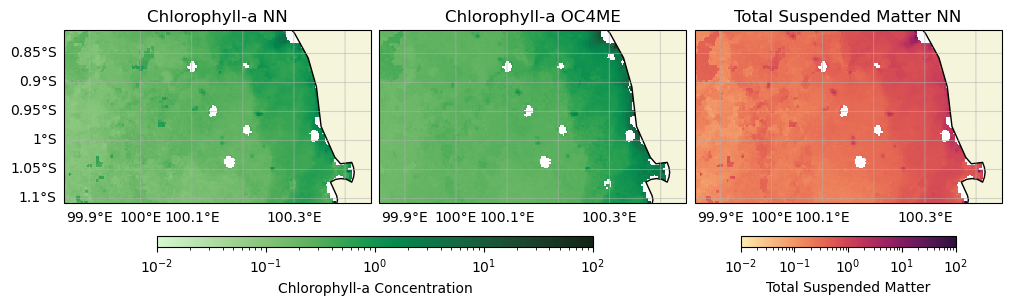

In [16]:
dataset = xr.open_dataset(os.path.join(result_dir, f'Sen-3_{str(ds.time[0].data)[0:10]}_{str(ds.time[-1].data)[0:10]}_{nick}.nc'), decode_coords='all')
dataset = dataset.mean(dim='time')

fig, ax = plt.subplots(figsize=[10,6], ncols = 3, layout='constrained', subplot_kw=dict(projection=ccrs.Robinson(central_longitude=112.0)))

for i in range(3):
    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cf.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)
    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i == 0:
        ini.left_labels = False

if parameters == 1:    
    cnn_plot = 10 ** dataset['chl_nn']
    coc_plot = 10 ** dataset['chl_oc4me']
    tsm_plot = 10 ** dataset['tsm_nn']
    
    cnn_plot.plot(ax=ax[0], add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
    ax[0].set_title("Chlorophyll-a NN")
    coc_plot.plot(ax=ax[1], add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
    ax[1].set_title("Chlorophyll-a OC4ME")
    tsm_plot.plot(ax=ax[2], add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.matter, transform=ccrs.PlateCarree(), zorder=0)
    ax[2].set_title("Total Suspended Matter NN")
    
    cbar1 = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(0.01,100), cmap=cmo.algae), shrink=0.7, aspect=40, pad=0.02, orientation = 'horizontal', label = 'Chlorophyll-a Concentration',ax=ax[0:2])
    cbar2 = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(0.01,100), cmap=cmo.matter), shrink=0.7, aspect=20, pad=0.02, orientation = 'horizontal', label = 'Total Suspended Matter',ax=ax[2:])

else:
    a06_plot = dataset['Oa06_reflectance']
    a08_plot = dataset['Oa08_reflectance']
    a12_plot = dataset['Oa12_reflectance']
    
    r1 = a06_plot.plot(ax=ax[0], norm=colors.Normalize(0,0.1), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[0].set_title("Oa06")
    fig.colorbar(r1, ax=ax[0], shrink=0.6, location='bottom')
    r2 = a08_plot.plot(ax=ax[1], norm=colors.Normalize(0,0.025), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[1].set_title("Oa08")
    fig.colorbar(r2, ax=ax[1], shrink=0.6, location='bottom')
    r3 = a12_plot.plot(ax=ax[2], norm=colors.Normalize(0,0.05), cmap=cmo.hawaii, transform=ccrs.PlateCarree(), zorder=0)
    ax[2].set_title("Oa12")
    fig.colorbar(r3, ax=ax[2], shrink=0.6, location='bottom')

plt.show()    

plt.savefig(download_dir,f'Mean_of_{nick}.png', dpi=300)